Models to Benchmark

API-Based via OpenRouter
*   deepseek/deepseek-llm
*   google/gemini-flash-1.5-8b
*   qwen/qwen3-8b
*   openai/gpt-4.0






Hugging Face
* mistralai/Mistral-7B-Instruct-v0.1
* t5-base
* t5-large
* google/mt5-large

In [1]:
!pip install transformers accelerate torch pdfplumber pytesseract pillow tabulate plotly psutil pygithub openrouter openai google-generativeai python-dotenv requests


In [2]:
!pip install -U kaleido plotly

In [3]:
from google.colab import files
uploaded = files.upload()
file_path = list(uploaded.keys())[0]


Saving Nikola Tesla.pdf to Nikola Tesla.pdf


In [4]:
import pdfplumber, pytesseract
from PIL import Image

def extract_text(fp):
    ext = fp.lower().split('.')[-1]
    if ext == 'pdf':
        with pdfplumber.open(fp) as pdf:
            return "\n".join([p.extract_text() or '' for p in pdf.pages])
    elif ext in ['jpg','png','jpeg']:
        return pytesseract.image_to_string(Image.open(fp))
    else:
        return open(fp,'r',encoding='utf-8').read()

text = extract_text(file_path)
print(text[:3768])


Nikola Tesla Biography
(c. 1856–1943)
UPDATED:
SEP 4, 2019
ORIGINAL:
FEB 26, 2015
•
•
•
•
•
Nikola Tesla was a scientist whose inventions include the Tesla coil,
alternating-current (AC) electricity, and the discovery of the rotating
magnetic field.
Who Was Nikola Tesla?
Nikola Tesla was an engineer and scientist known for designing the alternating-current (AC)
electric system, which is the predominant electrical system used across the world today. He also
created the "Tesla coil," which is still used in radio technology.
Born in modern-day Croatia, Tesla came to the United States in 1884 and briefly worked
with Thomas Edison before the two parted ways. He sold several patent rights, including those to
his AC machinery, to George Westinghouse.
Early Life
Tesla was born in Smiljan, Croatia, on July 10, 1856.
Tesla was one of five children, including siblings Dane, Angelina, Milka and Marica. Tesla's
interest in electrical invention was spurred by his mother, Djuka Mandic, who invented s

In [5]:
def build_prompt(text):
    snippet = text.strip()[:3768]
    return f"""You are the most creative teacher on earth. Read the following:\n\n{snippet}\n\nNow:\n1. Summarize in 3 sentences.\n2. Generate 5 flashcard questions WITH answers."""
prompt = build_prompt(text)


In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
import time, psutil

HF_MODELS = {
  "T5-base":"t5-base",
  "T5-large":"t5-large",
  "mT5-base":"google/mt5-base",
}


def run_hf_model(name, model_id, prompt):
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # Use the correct architecture

    model = AutoModelForSeq2SeqLM.from_pretrained(model_id).to("cuda")
    inputs = tokenizer(prompt, return_tensors="pt", max_length=3000, truncation=True).to(model.device)

    start = time.time()
    mem_before = psutil.Process().memory_info().rss
    outputs = model.generate(**inputs, max_new_tokens=3000)
    mem_after = psutil.Process().memory_info().rss
    end = time.time()

    result = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return {
        "model": name,
        "output": result,
        "time_sec": round(end - start, 2),
        "mem_mb": round((mem_after - mem_before) / 1024 / 1024, 2)
    }


In [14]:
from openai import OpenAI
import time
from google.colab import userdata
import requests
import json

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=userdata.get('Openai'),
)

API_MODELS = {
    "DeepSeek": "deepseek/deepseek-r1-0528-qwen3-8b:free",
    #"Gemini": "google/gemini-2.0-flash-exp:free",
    "Qwen3-8B": "qwen/qwen3-8b:free",
    "Mistral-Small-3.2" : "mistralai/mistral-small-3.2-24b-instruct:free"
}

def run_api_model(name, model_id, prompt):
    start = time.time()
    completion = client.chat.completions.create(
      model=model_id,
      messages=[
        {
          "role": "user",
          "content": prompt
        }
      ]
    )
    end = time.time()

    try:
        output = completion.choices[0].message.content
        return {
            "model": name,
            "output": output,
            "time_sec": round(end - start, 2),
            "mem_mb": 0
        }
    except Exception as e:
        return {"model": name, "output": f"Error: {str(e)}", "time_sec": 0, "mem_mb": 0}


In [8]:
results = []
for name, mid in HF_MODELS.items():
    print(f"⏳ Running HF model: {name}")
    results.append(run_hf_model(name, mid, prompt))



⏳ Running HF model: T5-base


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

⏳ Running HF model: T5-large


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

⏳ Running HF model: mT5-base


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [15]:
for name, mid in API_MODELS.items():
    print(f"🌐 Querying API model: {name}")
    results.append(run_api_model(name, mid, prompt))


🌐 Querying API model: DeepSeek
🌐 Querying API model: Qwen3-8B
🌐 Querying API model: Mistral-Small-3.2


In [36]:
import pandas as pd


df = pd.DataFrame(results)
display(df[["model", "time_sec", "mem_mb"]])
df.to_csv("model_metrics.csv", index=False)

,model,time_sec,mem_mb
0,T5-base,3.90,472.03
1,T5-large,4.59,0.90
2,mT5-base,0.38,1.56
3,DeepSeek,6.87,0.00
4,Qwen3-8B,7.66,0.00
5,Mistral-Small-3.2,6.24,0.00


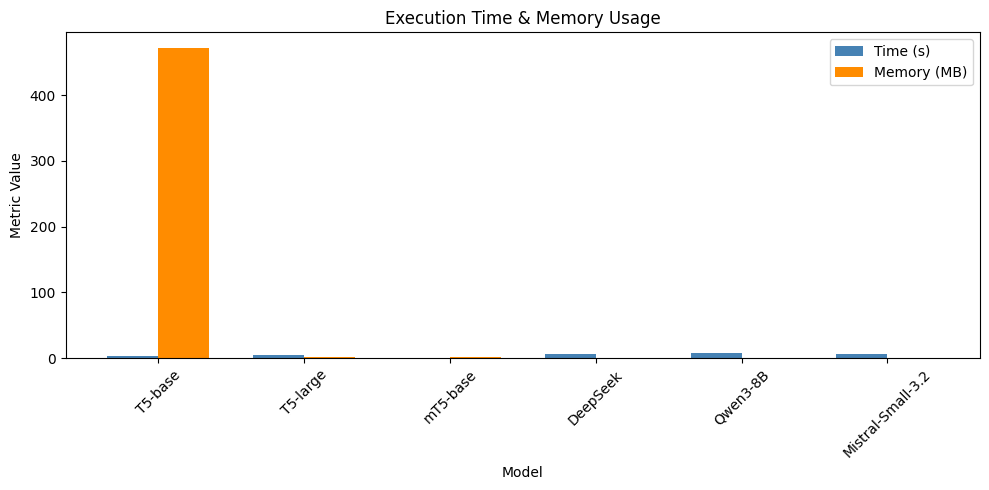

In [37]:
import matplotlib.pyplot as plt

# Grouped bar chart
plt.figure(figsize=(10, 5))
x = df['model']
time_vals = df['time_sec']
mem_vals = df['mem_mb']

bar_width = 0.35
indices = range(len(x))

plt.bar(indices, time_vals, bar_width, label='Time (s)', color='steelblue')
plt.bar([i + bar_width for i in indices], mem_vals, bar_width, label='Memory (MB)', color='darkorange')

plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.title('Execution Time & Memory Usage')
plt.xticks([i + bar_width / 2 for i in indices], x, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("resource_usage.png")
plt.show()


In [38]:
import os
report_md = f"""
# 📊 LLM Benchmark Report

## Models Tested
- Hugging Face: {', '.join(HF_MODELS.keys())}
- OpenRouter API: {', '.join(API_MODELS.keys())}

## Prompt Used
```\n{prompt}\n```

## Summary Table
{df.to_markdown(index=False)}

![Resource Usage](resource_usage.png)
"""

os.makedirs("reports", exist_ok=True)
with open("reports/report.md", "w") as f:
    f.write(report_md)

print("✅ Report written to reports/report.md")

✅ Report written to reports/report.md
